In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as ds
import torchvision.transforms as transforms
# import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
# import matplotlib.animation as animation
# from IPython.display import HTML

manualSeed = 999
print("Random Seed: ", manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)

Random Seed:  999


### 数据预处理 

1. [数据集](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)：
这是一个收集了大量名人头像的数据集,训练模型前需要将数据集解压到当前目录下

In [2]:
dataroot = "celeba"  # 上面解压的数据集地址，这里需要一个两层的目录(满足dataset loader的)
batch_size = 512
image_size = 64
num_epochs = 5
lr = 2e-4
use_gpu = True
feature_size = 64 # feature size  超参数
num_channel = 3  # picture channel 
generator_input_shape = (100,1,1) # 生成器白噪声尺寸


将会使用cuda:1进行模型训练


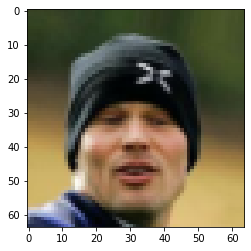

In [3]:
# 从目录创建数据集
dataset = ds.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size), # 将短边resize到 image_size
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(), # 把图像scale到0-1   hwc ->chw
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # scale到-1，1 ；函数给定每个channel的 mean和std，返回(x-mean)/std
                           ]))


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=5)

device = torch.device("cuda:1" if (torch.cuda.is_available() and use_gpu) else "cpu")
print(f'将会使用{device}进行模型训练')

# 显示一张dataset中的图片
batch_data = next(iter(dataloader))
plt.imshow(np.transpose((batch_data[0][0]+1)/2,(1,2,0))) # 这块需要反normalize一下

# 模型构建

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self, use_gpu, feature_size=feature_size,num_channel=num_channel):
        super(Generator, self).__init__()
        self.gpu = use_gpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( generator_input_shape[0], feature_size * 8, 4, 1, 0, bias=False), #反卷积  输入channel，输出channel
            nn.BatchNorm2d(feature_size * 8),
            nn.ReLU(True),
            # state size. (feature_size*8) x 4 x 4
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),
            # state size. (feature_size*4) x 8 x 8
            nn.ConvTranspose2d( feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),
            # state size. (feature_size*2) x 16 x 16
            nn.ConvTranspose2d( feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),
            # state size. (feature_size) x 32 x 32
            nn.ConvTranspose2d( feature_size, num_channel, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (num_channel) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
netG = Generator(use_gpu,feature_size=feature_size).to(device)
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, use_gpu,feature_size=feature_size,num_channel=num_channel):
        super(Discriminator, self).__init__()
        self.gpu = use_gpu
        self.main = nn.Sequential(
            # input is (num_channel) x 64 x 64
            nn.Conv2d(num_channel, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (feature_size) x 32 x 32
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (feature_size*2) x 16 x 16
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (feature_size*4) x 8 x 8
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (feature_size*8) x 4 x 4
            nn.Conv2d(feature_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
netD = Discriminator(use_gpu,feature_size).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
D_loss = nn.BCELoss() # 使用BinaryEntropyLoss

# 创建一个固定的随机输入，用来观察模型训练过程
fixed_noise = torch.randn(64, *generator_input_shape, device=device)

# 创建优化器
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr,betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr,betas=(beta1, 0.999))

In [10]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):

        ## 使用真实数据训练D
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = D_loss(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        average_D_real = output.mean().item()

        ## 使用生成数据训练D
        # Generate batch of latent vectors
        noise = torch.randn(b_size, *generator_input_shape, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(0)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)   # attention，the detach() will stop gredient
        # Calculate D's loss on the all-fake batch
        errD_fake = D_loss(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        average_D_G_fake_1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        #使用D训练G  让D认为G生成的图片是真实图片
        netG.zero_grad()
        label.fill_(1)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = D_loss(output, label)
        # Calculate gradients for G
        errG.backward()
        average_D_G_fake_2 = output.mean().item()
        # Update G
        optimizerG.step()


        if i % 100 == 0:
            print(f'{epoch:1d}-{i:04d}: D模型(真+假)loss:{errD.item():7.4f}; G模型(假as真)D_loss:{ errG.item():7.4f}; 真图D_out:{average_D_real:.4f}；'\
                    f'假图D_out:{average_D_G_fake_1:.4f}; 假图D_out(更新后):{average_D_G_fake_2:.4f}')

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
0-0000: D模型(真+假)loss: 1.7228; G模型(假as真)D_loss: 5.8588; 真图D_out:0.6341；假图D_out:0.6207; 假图D_out(更新后):0.0057
0-0100: D模型(真+假)loss: 0.2564; G模型(假as真)D_loss: 4.9795; 真图D_out:0.8516；假图D_out:0.0255; 假图D_out(更新后):0.0250
0-0200: D模型(真+假)loss: 0.6855; G模型(假as真)D_loss: 5.7794; 真图D_out:0.9008；假图D_out:0.3897; 假图D_out(更新后):0.0055
0-0300: D模型(真+假)loss: 0.6884; G模型(假as真)D_loss: 4.1190; 真图D_out:0.9189；假图D_out:0.3866; 假图D_out(更新后):0.0417
1-0000: D模型(真+假)loss: 0.4452; G模型(假as真)D_loss: 3.9628; 真图D_out:0.7541；假图D_out:0.0815; 假图D_out(更新后):0.0320
1-0100: D模型(真+假)loss: 1.0671; G模型(假as真)D_loss: 2.1278; 真图D_out:0.4837；假图D_out:0.0473; 假图D_out(更新后):0.1738
1-0200: D模型(真+假)loss: 0.7514; G模型(假as真)D_loss: 4.5987; 真图D_out:0.8260；假图D_out:0.3653; 假图D_out(更新后):0.0178
1-0300: D模型(真+假)loss: 0.5777; G模型(假as真)D_loss: 4.4198; 真图D_out:0.8621；假图D_out:0.2798; 假图D_out(更新后):0.0228
2-0000: D模型(真+假)loss: 0.5438; G模型(假as真)D_loss: 3.5377; 真图D_out:0.7426；假图D_out:0.1118; 假图D_out(更新后):0.0642
2-0100: D模型(真+假)loss

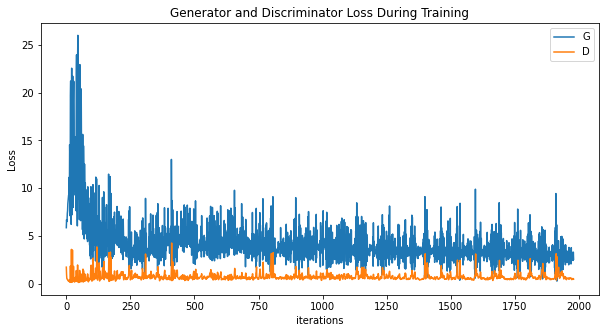

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 观察生成器在训练过程中的变化

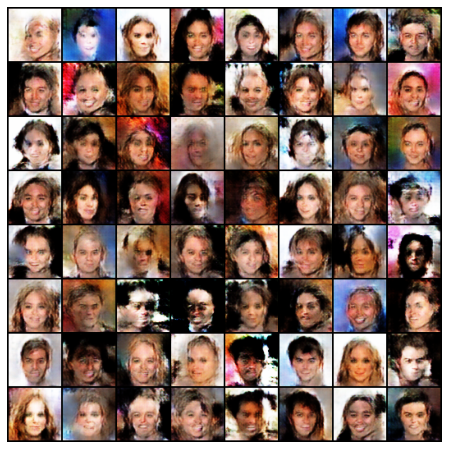

In [12]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## 对比真实数据何最终的生成数据

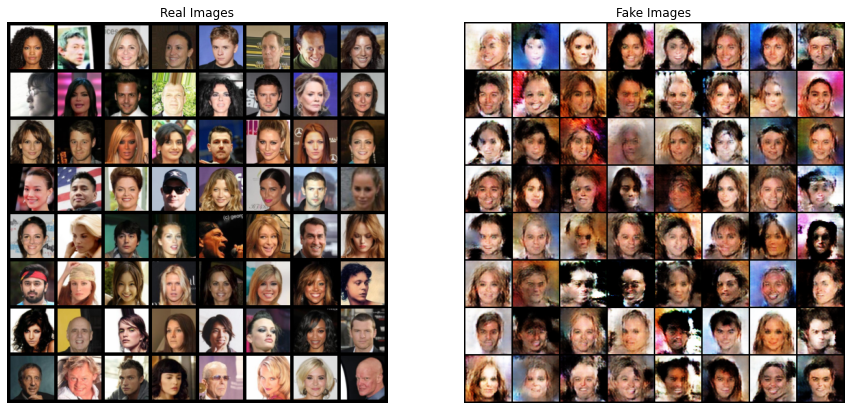

In [13]:

real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()